# Local Shape Descriptors Project
### CSE 185: Advanced Machine Learning

In [1]:
# packages
!pip install mrcfile
!pip install h5py
!pip install torch
!pip install gunpowder

# repos
# !pip install git+https://github.com/funkelab/funlib.learn.torch.git

## 

In [2]:
import numpy as np
import zarr
import h5py
import io 
import requests
import matplotlib.pyplot as plt

In [23]:
#@title utility function to view labels

# matplotlib uses a default shader
# we need to recolor as unique objects

def create_lut(labels):

    max_label = np.max(labels)

    lut = np.random.randint(
            low=0,
            high=255,
            size=(int(max_label + 1), 3),
            dtype=np.uint8)

    lut = np.append(
            lut,
            np.zeros(
                (int(max_label + 1), 1),
                dtype=np.uint8) + 255,
            axis=1)

    lut[0] = 0
    colored_labels = lut[labels]

    return colored_labels

In [4]:


shape = (25,)*3

raw = np.ones(shape=shape).astype(np.uint8)
labels = np.ones(shape=shape).astype(np.uint64)

out = zarr.open('data.zarr', 'a')

for ds_name, data in [
        ('raw', raw),
        ('labels', labels)]:

    out[ds_name] = data
    out[ds_name].attrs['offset'] = [0]*3
    out[ds_name].attrs['resolution'] = [50,10,10]

In [5]:
#@title utility  function to download / save data as zarr
url = 'https://cremi.org/static/data/sample_A_20160501.hdf' 
name = 'training_data.zarr'
offset = [0,0]
resolution = [4,4]
sections = None 
squeeze = True

in_f = h5py.File(io.BytesIO(requests.get(url).content), 'r')

in_f


<HDF5 file "<_io.BytesIO object at 0x7fd4c05f5bc0>" (mode r)>

In [6]:
in_f['annotations'].keys()

<KeysViewHDF5 ['comments', 'ids', 'locations', 'presynaptic_site', 'types']>

In [7]:
in_f['annotations/comments'].keys()

<KeysViewHDF5 ['comments', 'target_ids']>

In [8]:
print(in_f['annotations/comments/comments'][:])
print(in_f['annotations/comments/target_ids'][:])

[b'unsure' b'unsure' b'unsure' b'unsure' b'unsure' b'unsure' b'unsure'
 b'unsure' b'unsure' b'unsure' b'unsure' b'unsure' b'unsure' b'unsure'
 b'unsure' b'unsure' b'unsure']
[165 167 185 191 347 389 403 405 409 425 450 468 484 524 568 574 576]


In [9]:
in_f['annotations/locations'][:]

array([[  40.     ,  603.87885, 3519.4636 ],
       [  40.     ,  517.9027 , 3338.4175 ],
       [ 200.     ,  498.88873, 3701.3362 ],
       ...,
       [4040.     , 4274.3    , 4693.1416 ],
       [4040.     , 4269.092  , 4530.8203 ],
       [4040.     , 4384.5396 , 4552.521  ]], dtype=float32)

In [10]:
in_f['volumes'].keys()

<KeysViewHDF5 ['labels', 'raw']>

In [11]:
in_f['volumes/raw'].shape

(125, 1250, 1250)

In [12]:
in_f['volumes/raw'][0,:,:].shape

(1250, 1250)

In [13]:
in_f['volumes/labels'].keys()

<KeysViewHDF5 ['clefts', 'neuron_ids']>

In [14]:
in_f['volumes/labels/clefts'].shape

(125, 1250, 1250)

In [15]:
in_f['volumes/labels/neuron_ids'].shape

(125, 1250, 1250)

In [16]:
in_f['volumes/labels/neuron_ids'][20,:,:]

array([[  885,  7113,  7113, ...,  4357,  4357,  4357],
       [ 7113,  7113,  7113, ...,  4357,  4357,  4357],
       [ 7113,  7113,  7113, ...,  4357,  4357,  4357],
       ...,
       [13171, 13171, 13171, ...,  9627,  9627,  9627],
       [13171, 13171, 13171, ...,  9627,  9627,  9627],
       [13171, 13171, 13171, ...,  9627,  9627,  5903]], dtype=uint64)

In [17]:
raw = in_f['volumes/raw']
labels = in_f['volumes/labels/neuron_ids']

container = zarr.open(name, 'a')

if sections is None:
  sections=range(raw.shape[0]-1)

for index, section in enumerate(sections):

  print(f'Writing data for section {section}')

  raw_slice = raw[section]
  labels_slice = labels[section]

  if squeeze:
    raw_slice = np.squeeze(raw_slice)
    labels_slice = np.squeeze(labels_slice)

  for ds_name, data in [
      ('raw', raw_slice),
      ('labels', labels_slice)]:
      
      container[f'{ds_name}/{index}'] = data
      container[f'{ds_name}/{index}'].attrs['offset'] = offset
      container[f'{ds_name}/{index}'].attrs['resolution'] = resolution

Writing data for section 0
Writing data for section 1
Writing data for section 2
Writing data for section 3
Writing data for section 4
Writing data for section 5
Writing data for section 6
Writing data for section 7
Writing data for section 8
Writing data for section 9
Writing data for section 10
Writing data for section 11
Writing data for section 12
Writing data for section 13
Writing data for section 14
Writing data for section 15
Writing data for section 16
Writing data for section 17
Writing data for section 18
Writing data for section 19
Writing data for section 20
Writing data for section 21
Writing data for section 22
Writing data for section 23
Writing data for section 24
Writing data for section 25
Writing data for section 26
Writing data for section 27
Writing data for section 28
Writing data for section 29
Writing data for section 30
Writing data for section 31
Writing data for section 32
Writing data for section 33
Writing data for section 34
Writing data for section 35
Wr

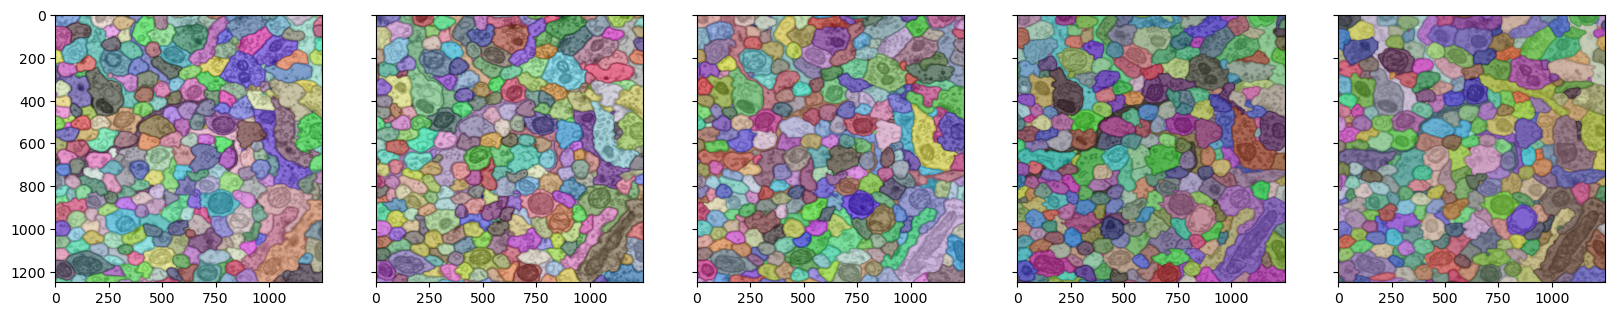

In [18]:
#view the first 5 sections of the volume

fig, axes = plt.subplots(
            1,
            5,
            figsize=(20, 6),
            sharex=True,
            sharey=True,
            squeeze=False)

for i in range(5):
  axes[0][i].imshow(zarr.open('training_data.zarr')[f'raw/{i}'][:], cmap='gray')
  axes[0][i].imshow(create_lut(zarr.open('training_data.zarr')[f'labels/{i}'][:]), alpha=0.5)

In [19]:
%cd /Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view

/Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view


In [20]:
%%bash
pwd

/Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view


In [21]:
import os
print(os.environ['PATH'])


/Users/vince/opt/anaconda3/envs/salk/bin:/Users/vince/opt/anaconda3/condabin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/bin


In [22]:
# Add IMOD to path
os.environ['PATH'] = '/Users/vince/google-cloud-sdk 2/bin:/Applications/IMOD/bin:/Users/vince/opt/anaconda3/bin:/Users/vince/opt/anaconda3/condabin:/opt/homebrew/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Applications/IMOD/pythonLink:/Users/vince/.cabal/bin:/Users/vince/.ghcup/bin:/Users/vince/Library/Mobile Documents/com~apple~CloudDocs/UCSD/Spring 2023/CSE 185/HOMER/.//bin/' + os.environ['PATH']

In [23]:
print(os.environ['PATH'])



/Users/vince/google-cloud-sdk 2/bin:/Applications/IMOD/bin:/Users/vince/opt/anaconda3/bin:/Users/vince/opt/anaconda3/condabin:/opt/homebrew/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Applications/IMOD/pythonLink:/Users/vince/.cabal/bin:/Users/vince/.ghcup/bin:/Users/vince/Library/Mobile Documents/com~apple~CloudDocs/UCSD/Spring 2023/CSE 185/HOMER/.//bin//Users/vince/opt/anaconda3/envs/salk/bin:/Users/vince/opt/anaconda3/condabin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/bin


In [37]:
!pwd

/Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view


In [38]:
os.getcwd()

'/Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view'

In [15]:
import numpy as np
import zarr
import os
from skimage import io
import subprocess
import mrcfile

path_dir = '/Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view'
IMAGE_FILE = os.path.join(path_dir, '3M-APP-SCN-3view-stack-final-bin2-trim_5-1290_5500-6500_600-700.mrc')
MOD_FILE = os.path.join(path_dir, '2023-02-28_CompImBio_precision_filtered.mod')
NUM_OBJECTS = 342


os.chdir(path_dir)
print(os.getcwd())

def load_mrc_data(filename: str) -> np.ndarray:
    # print('Loading', filename)
    with mrcfile.open(filename, mode='r') as mrc:
        data = mrc.data
        # print(type(data), data.shape)
    return data

def object_to_numpy(obj_id: int, temp_filename: str) -> np.ndarray:
    # Extract single object from mod file
    # imodextract 2 2023-02-28_CompImBio_precision_filtered.mod single_object.mod
    temp_modfile_path = os.path.join(path_dir, temp_filename+'.mod')
    print('temp_modfile_path', temp_modfile_path)
    subprocess.run(['/Applications/IMOD/bin/imodextract', str(obj_id), MOD_FILE, 
                    temp_modfile_path])
    print('Extracted object', obj_id, 'to', temp_modfile_path)

    # Run an IMOD command to generate a mask for the object
    temp_mrcfile_path = os.path.join(path_dir, temp_filename+'.mrc')
    print('temp_mrcfile_path', temp_mrcfile_path)
    subprocess.run(['/Applications/IMOD/bin/imodmop', '-mask', '1', 
                    temp_modfile_path, IMAGE_FILE, temp_mrcfile_path ])
    print('Generated mask for object', obj_id, 'to', temp_mrcfile_path)

    # Load the mask using a library like skimage or another suitable one
    mask = load_mrc_data(temp_mrcfile_path)
    print('Loaded mask for object', obj_id, 'from', temp_filename+'.mrc')

    # Convert the mask to a binary mask
    mask = (mask > 0).astype(np.uint64)
    print('Converted mask for object', obj_id, 'to binary. ', mask.shape)

    # # Remove the temporary file
    # os.remove(temp_mrcfile_path)
    # print('Removed temporary file', temp_filename+'.mrc')
    # os.remove(temp_mrcfile_path)
    # print('Removed temporary file', temp_filename+'.mod')

    return mask

# Initialize labels with the intercellular space
labels = np.zeros(shape=(100,1000,1000), dtype=np.uint64)
overlap_tracker = np.zeros_like(labels)

print('Looping over objects')
# Loop over each object
for obj_id in range(1,NUM_OBJECTS+1):
    temp_filename = os.path.join(path_dir, f'temp_mask_{obj_id}')
    print('Obj_id:', obj_id)
    mask = object_to_numpy(obj_id, temp_filename)

    # Find the indices where the mask is True
    mask_indices = np.where(mask)

    # Increment overlap_tracker at the locations where mask is True
    overlap_tracker[mask_indices] += 1

    # Assign label only at the locations where overlap_tracker is 1 (i.e., no overlap)
    labels[mask_indices] = np.where(overlap_tracker[mask_indices] == 1, obj_id, 0)
    break

print('Done')
# The shape of your raw data
shape = labels.shape
print('labels.shape', shape)


/Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view
Looping over objects
Obj_id: 1
temp_modfile_path /Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view/temp_mask_1.mod
Extracted object 1 to /Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view/temp_mask_1.mod
temp_mrcfile_path /Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view/temp_mask_1.mrc
Generated mask for object 1 to /Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view/temp_mask_1.mrc


/Applications/IMOD/bin/imodextract: line 3: /bin/realbin/imodextract: No such file or directory
/Applications/IMOD/bin/imodmop: line 3: /bin/realbin/imodmop: No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: '/Users/vince/Salk/AutoSeg/PSAPP-SCN_OPN_Retina-3view/temp_mask_1.mrc'

In [29]:
subprocess.run(['ls', '/bin/realbin/imodextract'])

ls: /bin/realbin/imodextract: No such file or directory


CompletedProcess(args=['ls', '/bin/realbin/imodextract'], returncode=1)

In [4]:
import subprocess
import os 
print(os.environ['PATH'])
subprocess.run(['imodmop'])

/Users/vince/opt/anaconda3/envs/salk/bin:/Users/vince/opt/anaconda3/condabin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/bin


FileNotFoundError: [Errno 2] No such file or directory: 'imodmop'

In [16]:
import mrcfile
import numpy as np

def load_raw_data(filename: str) -> np.ndarray:
    # with mrcfile.mmap(filename, mode='r') as mrc:
    with mrcfile.open(filename, mode='r') as mrc:
        data = mrc.data

    return data

raw = load_raw_data(IMAGE_FILE).astype(np.uint8)

out = zarr.open('data1.zarr', 'w')

for ds_name, data in [('raw', raw), ('labels', labels)]:
    print(ds_name, data.shape)
    out[ds_name] = data
    out[ds_name].attrs['offset'] = [0]*3
    out[ds_name].attrs['resolution'] = [50,10,10]  # pixel spacing is 10nm x 10nm x 50nm

raw (100, 1000, 1000)
labels (100, 1000, 1000)


In [28]:
type(labels)

numpy.ndarray

In [26]:
dz = zarr.open('data1.zarr')
dz['labels']

AttributeError: 'Array' object has no attribute 'keys'

In [1]:
!ls

AWS                         Piriform.zip
AWS_LSD                     SegEM
AutoSeg Notes               SyConn
CDeep3M2_G4                 data.zarr
IMOD Commands               datasetone
IMOD_scripts.ipynb          datasetone.zip
LSDs.ipynb                  gt_syconn_bird_sj_vc_mi.zip
PSAPP-SCN_OPN_Retina-3view  nnUNet
Piriform                    training_data.zarr


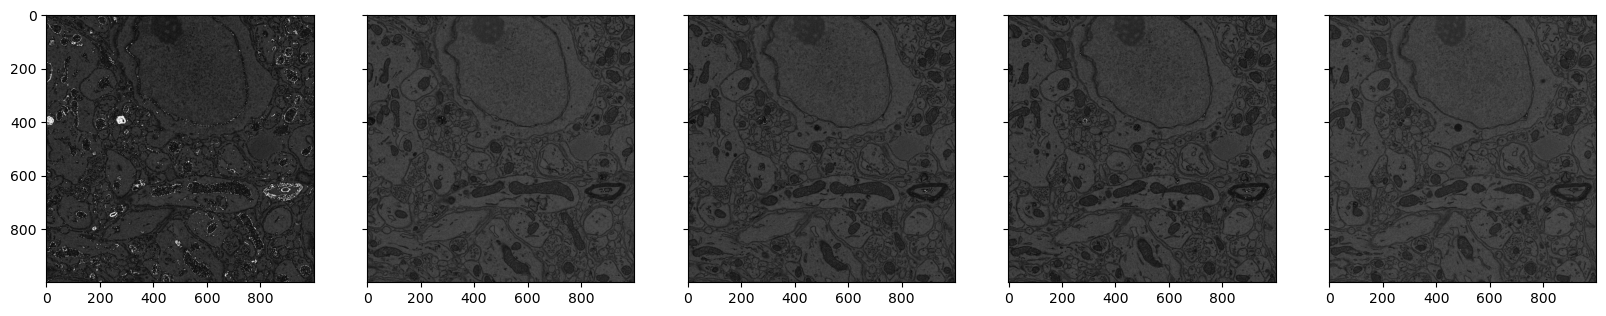

In [24]:
#view the first 5 sections of the volume
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
            1,
            5,
            figsize=(20, 6),
            sharex=True,
            sharey=True,
            squeeze=False)

for i in range(5):
  axes[0][i].imshow(zarr.open('data1.zarr')[f'raw/'][i, :], cmap='gray')
  axes[0][i].imshow(create_lut(zarr.open('data1.zarr')[f'labels/'][i, :]), alpha=0.5)